# Lab 2 Exercises for COMP 432 Machine Learning

In this lab you'll translate mathematics from lecture into practical Numpy code. Specifically, you'll implement _linear least squares regression_ and _logistic regression_ "from scratch" and compare the results of your own implementations to those of *scikit-learn*, a popular machine learning package.

<span style="color:red">Warning:</span> Many of the code cells in this notebook use the same simple variable names like `X` or `y` but assign them to be different data. If you run cells out of order, you may get unexpected results, so be careful when switching between exercises.

**Run the code cell below** to import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.linear_model

Lab2 requires a good understanding of Numpy and Matplotlib. Please complete Lab1 before attempting Lab2.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## 1. Gradient-based optimization

Exercises 1.1&ndash;1.3 are to help people who are unfamiliar with mathematical optimization or with implementing optimization in Numpy. The goal is to translate math into code on the simplest example possible.

<span style="color:red">*Note.*</span> We depict mathematical vectors as column-vectors but, in machine learning, it is often more convenient to stack $N$ vectors as if each vector were a row-vector, resulting in an $N \times D$ matrix rather than a $D \times N$ matrix. Similarly, the choice between whether to represent a Numpy vector as 1-dimensional ($\mathbb{R}^D$) or as an explicit row-vector ($\mathbb{R}^{1 \times D}$) or column-vector ($\mathbb{R}^{D \times 1}$) can be difficult.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.1 &mdash; Compute a simple gradient with Numpy

Consider the function
$$
f(\mathbf{x}) = \frac{1}{2}x_1^2 + (x_2-1)^2
$$

The gradient of this function is
$$
\nabla f(\mathbf{x}) = \begin{bmatrix}
\frac{\partial f}{\partial x_1}(\mathbf{x}) \\
\frac{\partial f}{\partial x_2}(\mathbf{x}) \\
\end{bmatrix}
= \begin{bmatrix}
x_1 \\
2(x_2-1) \\
\end{bmatrix}
$$

**Write two functions**, one that implements $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ and one that implements $\nabla f : \mathbb{R}^2 \rightarrow \mathbb{R}^2$. However, rather than assuming argument $\mathbf{x} \in \mathbb{R}^2$, you should assume the argument is actually an $N \times 2$ matrix where each row represents a distinct value of $\mathbf{x}$ to be evaluated. This is because the functions will be used by 'vectorized' code. Your code should likewise be vectorized, without using Python loops. 

In [38]:
def f(x):
    """
    Given an ndarray 'x' with shape (N,2), returns an ndarray with shape (N,)
    where the value at index i is function f(.) applied to row x[i].
    """
    x1, x2 = np.transpose(x)
    return ((1/2) * x1**2) + (x2 - 1)**2
    
def f_grad(x):
    """
    Given an ndarray 'x' with shape (N,2), returns an ndarray with shape (N,2)
    where the two values in row i are the gradient of f(.) applied to row x[i].
    """
    x1, x2 = np.transpose(x)
    result = np.zeros_like(x)
    result[:,0] = x1
    result[:,1] = 2*(x2 - 1)
    return result.squeeze();

**Check your answer** by running the code cell below

In [16]:
x = np.array([[3.5, 2.5], [-2.0, 0.5], [5.0, -3.0]])
y = f(x)
assert isinstance(y, np.ndarray), "Expected f(x) to return an ndarray"
assert y.shape == (len(x),), "Expected f(x) to return an ndarray of shape (N,)"
assert np.array_equal(y, [8.375, 2.25, 28.5]), "Wrong values returned by f(x):\n%s" % y
x_copy = x.copy()
g = f_grad(x_copy)
assert np.array_equal(x, x_copy), "f_grad(x) should not modify its argument"
assert isinstance(g, np.ndarray), "Expected f_grad(x) to return an ndarray"
assert g.shape == x.shape, "Expected f_grad(x) to return an ndarray of shape (N,2) when given "
assert np.array_equal(g, [[3.5,  3], [-2, -1], [5, -8]]), "Wrong values returned by f_grad(x):\n%s" % g
print("Correct!")

[[0. 0.]
 [0. 0.]
 [0. 0.]]
[ 3.5 -2.   5. ]
[ 2.5  0.5 -3. ]
[[ 3.5  3. ]
 [-2.  -1. ]
 [ 5.  -8. ]]
Correct!


<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.2 &mdash; Plotting $f(\mathbf{x})$ and $\nabla f(\mathbf{x})$ with vectorized code


If you plot the values of $f(\mathbf{x})$ from Exercise 1.1 using $\mathbf{x}=(x_1, x_2)$ over the square interval $[-3, 3]$, you can see the "shape" of the function. For example, if we use a grid size to $10 \times 10$ we get a coarse version of the plot:
![image](img/fig-exercise12-before-low.png)

If we use a grid size of $100 \times 100$ we get a smooth version:
![image](img/fig-exercise12-before.png)
We can see that the function has a global minimum at $\mathbf{x}=(0, 1)$.

Generating this kind of plot requires evaluating $f(\mathbf{x})$ at every point in a 2D grid interval. 
The above plot was generated by a single call to Matplotlib's **[imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html)** function. The argument to _imshow_ was a $100 \times 100$ matrix where entry $[i,j]$ was assigned value $f(\mathbf{x})$ for a specific $\mathbf{x}$ on the grid. The _imshow_ function automatically mapped different values of $f(\mathbf{x})$ to different colours on a scale.


In Python, efficiently evaluating $f(\mathbf{x})$ at 10000 distinct values of $\mathbf{x}$ requires vectorized code, so that $f$ can be called once on a big $1000 \times 2$ array rather than being called 10000 times on small arrays of size $2$. An initial plotting function is given in the code cell below. Run it to reproduce the above plot.

**Write additional lines of plotting code** to enhance the plot in two ways:
1. Overlay the contours of $f(\mathbf{x})$ using Matplotlib's **[contour](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html)** function.
2. Overlay the gradient field $\nabla f(\mathbf{x})$ using Matplotlib's **[quiver](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html)** function.

Your final plot should look something like this:
![image](img/fig-exercise12-solution.png)

To generate the gradient field in a vectorized manner, apply the *eval_func_on_grid* function directly to your *f_grad* implementation from Exercise 1.1. For a vector field it's best to use a smaller *gridsize*, like $10 \times 10$. If you do not understand how the vectorized code works, investigate by adding lines to print the shapes of arrays, like `print(x1.shape)`, and if that fails try asking a TA.

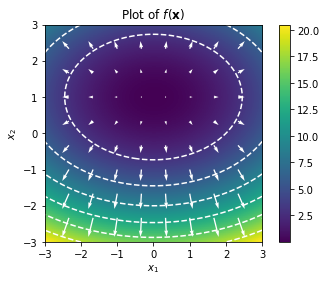

In [40]:
def eval_func_on_grid(func, gridsize):                # (You should be able to understand the code in this function)
    steps = np.linspace(-3, 3, gridsize)              # Make list of distinct grid values ranging from -3 to 3
    x1, x2 = np.meshgrid(steps, steps)                # Build a grid (x1[i,j], x2[i,j]) of distinct x values for each (i, j)
    x = np.column_stack([x1.ravel(), x2.ravel()])     # Stack each pair of x values into a new (gridsize*gridsize, 2) array
    y = func(x)                                       # Apply 'func', expecting a (gridsize*gridsize, :) array of outputs
    y = y.reshape(gridsize, gridsize, -1).squeeze()   # Reshape y from (gridsize*gridsize, :) to (gridsize, gridsize, :)
    return x1, x2, y

def plot_exercise12():
    # Evaluate f(x) on a dense 100x100 grid and plot it
    x1, x2, y = eval_func_on_grid(f, 100)
    
    # Plot the (100,100)
    plt.imshow(y, origin='lower', extent=(x1.min(), x1.max(), x2.min(), x2.max()))
    plt.colorbar()

    # Configure the plot
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.title('Plot of $f(\\mathbf{x})$')
    plt.gca().set_aspect('equal')  # Force the x and y axes to scale

    plt.contour(x1, x2, y, colors='white', linestyles='dashed')
    x3, x4, y2 = eval_func_on_grid(f_grad, 10)
    plt.quiver(x3, x4, y2[:,:,0], y2[:,:,1], color='white')
    
plot_exercise12()

<div style="border-bottom: 3px solid black;"></div>

### Exercise 1.3 &mdash; Implement gradient descent on a simple function

Gradient descent is an iterative algorithm that repeatedly takes steps in the direction opposite the gradient:

$$
\mathbf{x}_\text{new} = \mathbf{x}_\text{old} - \eta \nabla f(\mathbf{x}_\text{old})
$$

The step size is scaled by the *learning rate*, which is chosen to be some constant $\eta \gt 0$.

**Write a function** that runs several steps of gradient descent on the function $f$ from Exercise 1.1. Use the *f_grad* function that you wrote for Exercise 1.1.

In [36]:
def gradient_descent_on_f(x_init, learn_rate, num_steps):
    """
    Runs num_steps of gradient descent from point x_init using
    the given learning rate, and returns the new x coordinate.
    """
    for step in range(num_steps):
        x_init = x_init - learn_rate * f_grad(x_init)
    return x_init

**Check your answer** by running the code cell below

In [39]:
x = gradient_descent_on_f(np.array([[0, 1]]), 100.0, 1)
assert isinstance(x, np.ndarray), "Expected ndarray"
assert np.array_equal(x, [[0, 1]]), "Gradient descent shouldn't move away from optimal value!"
x = gradient_descent_on_f(np.array([[1, -2]]), 0.25, 1)
assert np.array_equal(x, [[0.75, -0.5]]), "The first gradient step seems to be wrong!"
x = gradient_descent_on_f(x, 0.1, 3)
assert np.allclose(x, [[0.54675, 0.232]]), "The gradient seems to be wrong after a few steps!"
print("Correct!")

Correct!


**Plot the path of gradient descent** by running the code cell below. You should see a path of little red 'x' marks that converge near $\mathbf{x}^*=(0,1)$.

Your final plot should look something like this:
![image](img/fig-exercise13-solution.png)

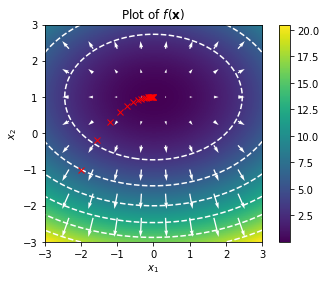

In [41]:
# Plot the loss surface and level contours first.
plot_exercise12()

# Run gradient descent in chunks of 5 steps at a time, plotting the resulting 'x' after each chunk
learn_rate = 0.05
x_init = np.array([[-2.0, -1.0]])                             # Start from initial point (-2, -1)
for num_steps in range(0, 100, 5):                            # Repeatedly run gradient descent from the initial point,
    x = gradient_descent_on_f(x_init, learn_rate, num_steps)  # eventually running it for 100 steps.
    plt.plot(*x[0], 'xr');                                    # Add a little 'x' to the plot to show how far it got.

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## 2. Linear least squares regression

Exercises 2.1&ndash;2.5 ask you to implement linear least squares regression, and to compare your results to applying the scikit-learn **[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)** model.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.1 &mdash; Vectorized code for generating predictions from a basic linear model

Recall from Lecture 1 that a basic linear model has the form:
$$
\hat{y}(\mathbf{x}, \mathbf{w}) = \mathbf{x}^T \mathbf{w}
$$
where 
$$
\begin{align}
\mathbf{x} &= \begin{bmatrix} 1 & x_1 & \ldots & x_D \end{bmatrix}^T\\
\mathbf{w} &= \begin{bmatrix} w_0 & w_1 & \ldots & w_D \end{bmatrix}^T
\end{align}
$$

If both $\mathbf{x}$ and $\mathbf{w}$ are column vectors, the following Python function would evaluate the linear model $\hat{y}(\mathbf{x}, \mathbf{w})$ correctly:
```python
def linear_model_predict(x, w):
    """Returns a prediction from linear model y(x, w) at point x using parameters w."""
    return x.T @ w   # Return the inner product (dot product) of vectors x and w
```
However, we want a version of *linear_model_predict* that vectorizes across many $\mathbf{x}$ simultaneously. Specifically, given a matrix of inputs:

$$
X = \begin{bmatrix}
\mathbf{x}_1^T\\
\vdots \\
\mathbf{x}_N^T
\end{bmatrix}
$$

we want *linear_model_predict* to compute a vector of outputs:

$$
\hat{\mathbf{y}} = \begin{bmatrix}
\mathbf{x}_1^T \mathbf{w}\\
\vdots\\
\mathbf{x}_N^T \mathbf{w}
\end{bmatrix}
$$

However, if we substitute $x$ with $X$ we can no longer use expression `X.T @ w`; the matrix $X^T \in \mathbb{R}^{(D+1) \times N}$ isn't even the right shape to be on the left-hand side of the product. Writing vectorized code is full of annoying little problems like this.

**Write a function** that evaluates the linear model in vectorized fashion. Specifically, when given a matrix $X \in \mathbb{R}^{N \times (D+1)}$ as an argument, you should figure out what mathematical expression would result in the $\hat{\mathbf{y}}\in\mathbb{R}^N$ vector shown above. Hint: the solution is only a small change from `X.T @ w`.

In [58]:
def linear_model_predict(X, w):
    """
    Returns predictions from linear model y(X, w) at each point X[i,:] using parameters w.
    Given X with shape (N,D+1), w must have shape (D+1,) and the result will have shape (N,).
    """
    return X @ w

**Check your answer** by running the code cell below.

In [59]:
w = np.array([2, 0.5])                            # Parameters corresponding to the 1D line y = 2 + 0.5*x1
X = np.array([[1., -3.], [1.,  3.], [1.,  5.]])   # Evaluate at x1 = -3, 2, 5
y = linear_model_predict(X, w)                    # Predict y for all X using w
assert isinstance(y, np.ndarray), "Expected an ndarray!"
assert np.array_equal(y, [0.5, 3.5, 4.5]), "Wrong predictions!\n%s" % y
try:
    y = linear_model_predict(X, w.reshape(-1, 1))
except ValueError:
    raise AssertionError("Your answer works when 'w' is 1-dimensional, but not when it is a column vector. Try again.")
w = np.array([1, 0.5, 0.25])                      # Parameters corresponding to the 2D plane y = 1 + 0.5*x1 + 0.25*x2
X = np.array([[1., -3., 1.], [1.,  3., 0.], [1.,  5., -2.]])   # Evaluate at different (x1, x2) points
y = linear_model_predict(X, w)                    # Predict y for all X using w
assert np.array_equal(y, [-0.25, 2.5, 3.0]), "Wrong predictions for 2-dimensional feature space!\n%s" % y
print("Correct!")

Correct!


**Plot several predictions at once** by running the code cell below.

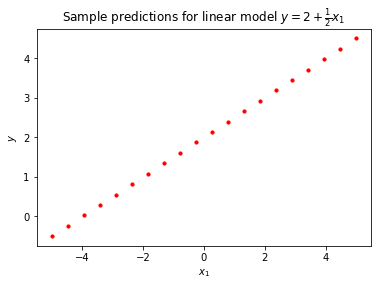

In [112]:
w = np.array([2, 0.5])           # Parameters corresponding to the 1D line y = 2 + 0.5*x1
x0 = np.ones(20)                 # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 20)      # A column of x values ranging from [-5, 5]
X = np.column_stack([x0, x1])    # A 20x2 matrix where X[i,:] is the ith x vector
y = linear_model_predict(X, w)   # Evaluate all x values
plt.scatter(x1, y, 10, 'r')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for linear model $y=2 + \\frac{1}{2}x_1$");

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.2 &mdash; Linear least squares regression by gradient descent

Here you'll implement a 'learning' algorithm for linear least squares regression. Recall from Lecture 1 that the least squares training objective is:

$$
\ell(\mathbf{w}) = \frac{1}{2} \sum_{i=1}^N (y - \hat{y}(\mathbf{x}_i, \mathbf{w}))^2
$$

The gradient for the above training objective is on the slide titled "Linear least squares *learning*" from Lecture 1. You'll need it.

**Write a function** to implement linear least squares regression by gradient descent. Use the `@` operator (matrix multiplication) in your answer.

In [92]:
def linear_regression_by_gradient_descent(X, y, w_init, learn_rate=0.05, num_steps=500):
    """
    Fits a linear model by gradient descent.
    
    If the feature matrix X has shape (N,D) the targets y should have shape (N,)
    and the initial parameters w_init should have shape (D,).
    
    Returns a new parameter vector w that minimizes the squared error to the targets.
    """
    w = w_init
    for step in range(num_steps):
        gradient = ((X.T @ X) @ w) - (X.T @ y)
        w = w - (gradient * learn_rate)
    return w

**Check your answer** by running the code cell below.

In [91]:
X = np.array([[1, 0.0], [1, 1.0], [1, 2.0]])
y = np.array([4.0, 3.0, 2.0])
w = linear_regression_by_gradient_descent(X, y, np.array([0.0, 0.0]))
assert isinstance(w, np.ndarray), "Expected ndarray!"
assert w.shape == (2,), "Wrong shape for final parameters!\n%s" % w
assert np.allclose(w, [4, -1]), "Wrong values for final parameters!\n%s" % w
print("Correct!")

Correct!


<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.3 &mdash; Linear least squares regression by direct solution

As discussed in class, the optimal parameters $\mathbf{w}^*$ for linear least squares regression can be solved *directly*, rather than iteratively.

**Write a function** to solve linear least squares regression directly. Use Numpy's matrix inverse function **[np.linalg.inv](https://numpy.org/devdocs/reference/generated/numpy.linalg.inv.html)** in your answer.

In [148]:
def linear_regression_by_direct_solve(X, y):
    """Fits a linear model by directly solving for the optimal parameter vector w."""
    return np.linalg.inv(X.T @ X) @ y

In [147]:
w = linear_regression_by_direct_solve(X, y)
assert isinstance(w, np.ndarray), "Expected ndarray!"
assert w.shape == (2,), "Wrong shape for final parameters!\n%s" % w
assert np.allclose(w, [4, -1]), "Wrong values for final parameters!\n%s" % w
print("Correct!")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.4 &mdash; Run linear least squares regression and plot the result

For this exercise you'll need to define Numpy arrays that correspond to the following training data:

$$
X = \begin{bmatrix}
1 & -2.2\\
1 & -0.3\\
1 &  1.5\\
1 &  4.8
\end{bmatrix}, \quad
\mathbf{y} = \begin{bmatrix}
-1.2 \\
1.5\\
4.2\\
5.3
\end{bmatrix}
$$

**Write code** to create the following plot:
![image](img/fig-linear-regression-1d-train-and-test.png)

Your code should follow this sequence of steps:
1. Make ndarrays $X$ and $\mathbf{y}$ that contain the above training set.
2. Plot the training set in blue. Use the $x$ coordinates from the second column of $X$, ignoring the first column.
3. Run linear least squares regression on $(X, \mathbf{y})$ to get fitted parameters $\mathbf{w}$; use your *linear_regression_by_direct_solve* function.
4. Define a "test set" of 20 equally-spaced values of $x$ in range $[-5, 5]$. You will need to build a new matrix $X_\text{test}$ with $1$ in the first column and the 20 distinct $x$ values in the second column. See how this is done in the last code cell of Exercise 2.1.
5. Predict 20 $y$ values corresponding to the 20 rows of $X_\text{test}$ by applying a linear model with your fitted parameters $\mathbf{w}$. Do this with single call to your *linear_model_predict* function. 
6. Plot the predictions on the test set.

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 2)

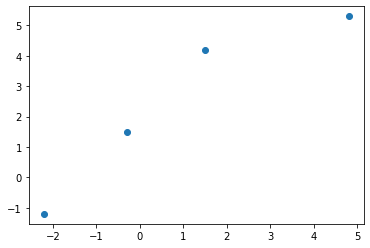

In [196]:
# i couldnt figure out how to not use a list :(
X = np.array([[1, -2.2], [1, -0.3], [1, 1.5], [1, 4.8]])
y = np.array([-1.2, 1.5, 4.2, 5.3])

plt.scatter(X[:,1], y, label='Training Points')

# and my direct solve doesnt work right :(
w = linear_regression_by_direct_solve(X, y)

ones = np.ones(20)
fives = np.arange(-5, 5.52631579, 0.52631579)
testSetX = np.stack([ones, fives], axis=1)
testSetY = linear_model_predict(testSetX, w)

plt.scatter(x1, testSetY, label='Test Predictions')


<div style="border-bottom: 3px solid black;"></div>

### Exercise 2.5 &mdash; Run scikit-learn LinearRegression

The scikit-learn package provides a **[LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)** object to perform linear least squares regression (also known as "ordinary" least squares).

**Write code to fit a LinearRegression model** using the same training matrix $X$ that you defined as part of Exercise 2.4. There are only two steps:
1. Create the _LinearRegression_ object. Use the *fit_intercept=False* option when creating the *LinearRegression* object (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)), since the $X$ matrix already has a column of 1s corresponding to an intercept parameter (the 'bias' parameter).
2. Fit the _LinearRegression_ object to the training matrix $X$ and targets $\mathbf{y}$. Use the object's **[fit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit)** method.

The variable holding a reference to your _LinearRegression_ object should be called `linear_model`, so that your answer can be checked.

In [152]:
linear_model = sklearn.linear_model.LinearRegression(fit_intercept=False)
linear_model.fit(X, y)

LinearRegression(fit_intercept=False)

**Check your answer** by running the code cell below. 

In [153]:
assert 'linear_model' in globals(), "You didn't create a variable named 'linear_model'!"
assert isinstance(linear_model, sklearn.linear_model.LinearRegression), "Expected a LinearRegression instance!"
assert hasattr(linear_model, 'coef_'), "No model coefficients yet! You didn't fit the model to any data!"
assert linear_model.intercept_ == 0.0, "You forgot to disable fitting of the intercept!"
assert np.allclose(linear_model.coef_, [[1.57104472, 0.92521608]]), "The model parameters you learned seem incorrect!"
print("Correct!")

Correct!


**Plot several LinearRegression model predictions at once** by running the code cell below.

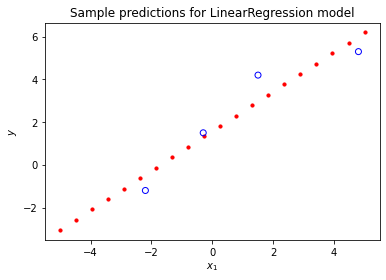

In [154]:
x0 = np.ones(20)                        # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 20)             # A column of x values ranging from [-5, 5]
X_test = np.column_stack([x0, x1])      # A 20x2 matrix where X[i,:] is the ith x vector
y_test = linear_model.predict(X_test)   # Evaluate all x values
plt.scatter(x1, y_test, 10, 'r')
plt.scatter(X[:,1], y, edgecolor='b', facecolor='none')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for LinearRegression model");

You can also compare the model's `coef_` attribute (coefficients, i.e. model parameters) to the parameter vector $\mathbf{w}$ that your own implementation gave from Exercise 2.4 (just use `print(w)` in your previous answer to see those values).

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## 3. Logistic regression

Exercises 3.1&ndash;3.4 ask you to implement logistic regression, and to compare your results to applying the scikit-learn **[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** model.

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.1 &mdash; Vectorized code for generating predictions from a logistic model 

Recall from Lecture 1 that the logistic model has the form:
$$
\hat{y}(\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{x}^T \mathbf{w})
$$

where $\mathbf{x}$ and $\mathbf{w}$ are the same as for Exercise 2.1 and $\sigma(\cdot)$ is the logistic sigmoid function described in Lecture 1.

**Write a function** that evaluates the logistic model in vectorized fashion, just like you did for Exercise 2.1.

In [156]:
def sigmoid(z):
    """Returns the element-wise logistic sigmoid of z."""
    return 1 / (1 + np.exp(-z))
    
def logistic_model_predict(X, w):
    """
    Returns predictions from logistic model y(x, w) at each point X[i,:] using parameters w.
    Given X with shape (N,D+1), w must have shape (D+1,) and the result will have shape (N,).
    """
    squish = X @ w
    return sigmoid(squish)

**Check your answer** by running the code cell below.

In [157]:
y = sigmoid(np.array([-1., 0., 1.5]))
assert isinstance(y, np.ndarray), "Expected an ndarray!"
assert np.allclose(y, [0.26894142, 0.5, 0.81757448]), "Values from sigmoid() appear to be wrong!"
w = np.array([2, 1.5])                           # Parameters corresponding to logistic model y = sigmoid(2 + 1.5*x1)
X = np.array([[1., -2.], [1.,  0.], [1.,  2.]])  # Evaluate at x1 = -2, 0, 2
y = logistic_model_predict(X, w)                 # Predict y for all X using w
assert isinstance(y, np.ndarray), "Expected an ndarray!"
assert np.allclose(y, [0.26894142, 0.88079708, 0.99330715]), "Wrong returned!\n%s" % y
try:
    y = logistic_model_predict(X, w.reshape(-1, 1))
except ValueError:
    raise AssertionError("Your answer works when 'w' is 1-dimensional, but not when it is a column vector. Try again.")
w = np.array([1, 0.5, 0.25])                      # Parameters corresponding to the 2D plane y = 1 + 0.5*x1 + 0.25*x2
X = np.array([[1., -3., 1.], [1.,  3., 0.], [1.,  5., -2.]])   # Evaluate at different (x1, x2) points
y = logistic_model_predict(X, w)                  # Predict y for all X using w
assert np.allclose(y, [0.4378235, 0.92414182, 0.95257413]), "Wrong predictions for 2-dimensional feature space!\n%s" % y
print("Correct!")

Correct!


**Plot several predictions at once** by running the code cell below.

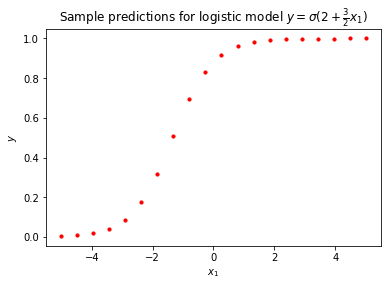

In [158]:
w = np.array([2, 1.5])                       # Parameters corresponding to logistic model y = sigmoid(2 + 1.5*x1)
x0 = np.ones(20)                             # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 20)                  # A column of x values ranging from [-5, 5]
X_test = np.column_stack([x0, x1])           # A 20x2 matrix where X[i,:] is the ith x vector
y_test = logistic_model_predict(X_test, w)   # Evaluate all x values
plt.scatter(x1, y_test, 10, 'r')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for logistic model $y=\sigma(2 + \\frac{3}{2}x_1)$");

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.2 &mdash; Logistic regression by gradient descent

Recall from Lecture 1 that the basic logistic regression training objective (learning objective) is:

$$
\ell_\text{LR}(\mathbf{w}) = \sum_{i=1}^N y_i \ln \sigma(\mathbf{w}^T \mathbf{x}_i) + (1-y_i) \ln \left(1-\sigma(\mathbf{w}^T \mathbf{x}_i)\right)
$$

The "basic" gradient for the above training objective is on a slide titled "Maximum likelihood estimate for LR" from Lecture 1, and reproduced here:

$$
\nabla \ell_\text{LR}(\mathbf{w}) = \sum_{i=1}^N (\sigma(\mathbf{w}^T \mathbf{x}_i) - y_i)\mathbf{x}_i
$$

**Write a function** to implement logistic regression by gradient descent. Your answer to _logistic_regression_grad_ should ideally be fully vectorized (no for-loops), but this may take a while to figure out. If you can't figure out the vectorization, it's OK &mdash; just compute the gradient however you can. Your answer to _logistic_regression_ should use your _logistic_regression_grad_ function to compute the gradient at each step.

Implementing _logistic_regression_grad_ is the hardest exercise in this lab because a vectorized implementation requires using the `@` matrix multiply operator to compute all the $\mathbf{w}^T \mathbf{x}$ products, reshaping the vector of residuals into a column-vector to use Numpy's broadcasting feature, and then summing over a specific axis (over training cases $i=1,\ldots,N$).

In [184]:
def logistic_regression_grad(X, y, w):
    """Returns the gradient for basic logistic regression."""
    return (sigmoid(X @ w) - y) @ X

def logistic_regression(X, y, w_init, learn_rate=0.05, num_steps=500):
    """
    Fits a logistic model by gradient descent.
    
    If the feature matrix X has shape (N,D) the targets y should have shape (N,)
    and the initial parameters w_init should have shape (D,).
    
    Returns a new parameter vector w that minimizes the negative log likelihood of the targets.
    """
    w = w_init
    for step in range(num_steps):
        gradient = logistic_regression_grad(X, y, w)
        w = w - (gradient * learn_rate)
    return w

**Check your answer** by running the code cell below.

In [183]:
X = np.array([[1, -1.0], [1, 1.0], [1, 2.0]])
y = np.array([0.0, 0.0, 1.0])
grad = logistic_regression_grad(X, y, np.array([0.0, 1.0]))
assert isinstance(grad, np.ndarray), "Expected ndarray from logistic_regression_grad!"
assert grad.shape == (2,), "Expected gradient to have shape (2,) but was %s" % (grad.shape,)
assert np.allclose(grad, [0.88079708, 0.22371131]), "Wrong value for gradient!"
grad = logistic_regression_grad(X, y, np.array([-1.0, 1.5]))
assert np.allclose(grad, [0.57911459, 0.30819531]), "Wrong value for gradient!"
w = logistic_regression(X, y, np.array([1.0, 0.0]))
assert isinstance(w, np.ndarray), "Expected ndarray from logistic_regression!"
assert w.shape == (2,), "Expected parameter vector w to have shape (2,) but was %s" % (w.shape,)
assert np.allclose(w, [-4.14100532, 2.95489589]), "Parameters found by gradient descent seem wrong!"
print("Correct!")

Correct!


### Exercise 3.3 &mdash; Run logistic regression on data and plot the result

For this exercise you'll need to define Numpy arrays that correspond to the following training data:

$$
X = \begin{bmatrix}
1 & -4.1\\
1 & -2.8\\
1 & -0.7\\
1 &  3.5
\end{bmatrix}, \quad
\mathbf{y} = \begin{bmatrix}
0 \\
0\\
1\\
1
\end{bmatrix}
$$

**Write code** to create the following plot:
![image](img/fig-logistic-regression-1d-train-and-test.png)

Your code should follow this sequence of steps, which are the same as for Exercise 2.4:
1. Make ndarrays $X$ and $\mathbf{y}$ that contain the above training set.
2. Plot the training set in blue. Use the $x$ coordinates from the second column of $X$, ignoring the first column.
3. Run logistic regression on $(X, \mathbf{y})$ to get fitted parameters $\mathbf{w}$; use your *logistic_regression* function, starting from $\mathbf{w}_\text{init} = \begin{bmatrix} 0.0, 1.0 \end{bmatrix}^T$
4. Define a "test set" of 20 equally-spaced values of $x$ in range $[-5, 5]$. You will need to build a new matrix $X_\text{test}$ with $1$ in the first column and the 20 distinct $x$ values in the second column.
5. Predict 20 $y$ values corresponding to the 20 rows of $X_\text{test}$ by applying a logistic model with your fitted parameters $\mathbf{w}$. Do this with single call to your *logistic_model_predict* function. 
6. Plot the predictions on the test set.

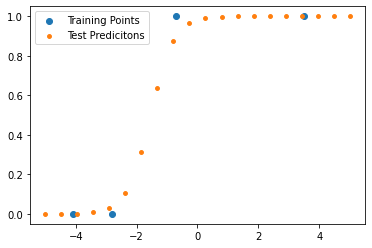

In [205]:
X = np.array([[1, -4.1], [1, -2.8], [1, -0.7], [1, 3.5]])
y = np.array([0, 0, 1, 1])

plt.scatter(X[:,1], y, label='Training Points')

w = logistic_regression(X, y, np.arange(0, 2, dtype='float32'))

ones = np.ones(20)
fives = np.arange(-5, 5.52631579, 0.52631579)
testSetX = np.stack([ones, fives], axis=1)

yValues = logistic_model_predict(testSetX, w)
# 6. Plot the test predictions. Aim for 1 line, plus a few lines to configure the plot (axis labels etc).
plt.scatter(x1, yValues, 15, label='Test Predicitons')
plt.legend()

<div style="border-bottom: 3px solid black;"></div>

### Exercise 3.4 &mdash; Run scikit-learn LogisticRegression

The scikit-learn package provides a **[LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)** object to perform logistic regression.

**Write code to fit a LogisticRegression model** using the same training matrix $X$ that you defined as part of Exercise 3.3. There are only two steps:
1. Create the _LogisticRegression_ object. Use the *fit_intercept=False*, *penalty='none'*, and *solver='lbfgs'* options when creating the *LogisticRegression* object (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)). (L-BFGS is a more powerful gradient-based solver than mere gradient descent.)
2. Fit the _LogisticRegression_ object to the training matrix $X$ and targets $\mathbf{y}$. Use the object's **[fit](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit)** method.

The variable holding a reference to your _LogisticRegression_ object should be called `logistic_model`, so that your answer can be checked.

A tweet regarding the fact that scikit-learn's LogisticRegression object applies regularization (a weight penalty) "by default":
![image](img/fig-logistic-regression-regularization-tweet.png)

In [206]:
logistic_model = sklearn.linear_model.LogisticRegression(fit_intercept=False, penalty='none', solver='lbfgs')
logistic_model.fit(X, y)

LogisticRegression(fit_intercept=False, penalty='none')

**Check your answer** by running the code cell below.

In [207]:
assert 'logistic_model' in globals(), "You didn't create a variable named 'logistic_model'!"
assert isinstance(logistic_model, sklearn.linear_model.LogisticRegression), "Expected a LogisticRegression instance!"
assert hasattr(logistic_model, 'coef_'), "No model coefficients yet! You didn't fit the model to any data!"
assert logistic_model.intercept_ == 0.0, "You forgot to disable fitting of the intercept!"
assert np.allclose(logistic_model.coef_, [[18.5251137, 10.49283446]]), "The parameters seem incorrect! Not L-BFGS?"
print("Correct!")

Correct!


Notice that the model parameters (coefficients) found by the _LogisticRegression_ are much larger than those found by your gradient descent solver. That is only because scikit-learn uses a more powerful optimization algorithm and can learn very sharp decision boundaries in fewer steps than mere gradient descent can. If you increase your *num_steps* argument your solver will find similarly large coefficients.

**Plot several LogisticRegression predictions at once** by running the code cell below.

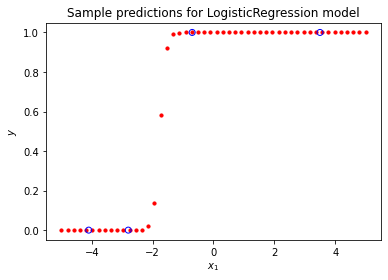

In [208]:
x0 = np.ones(50)                               # A column of 1s so that the bias term w[0] gets added
x1 = np.linspace(-5, 5, 50)                    # A column of x values ranging from [-5, 5]
X_test = np.column_stack([x0, x1])             # A 20x2 matrix where X[i,:] is the ith x vector
y_test = logistic_model.predict_proba(X_test)  # Evaluate all x values and get two probabilities back (class 0, class 1)
plt.scatter(x1, y_test[:,1], 10, 'r')          # Plot probability of class 1 only
plt.scatter(X[:,1], y, edgecolor='b', facecolor='none')
plt.xlabel("$x_1$")
plt.ylabel("$y$")
plt.title("Sample predictions for LogisticRegression model");